In [1]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
os.makedirs(outdir, exist_ok=True)

In [2]:
# load gwas meta-data
gwas_meta = pd.read_table('config/gwas.samplesheet.tsv')
gwas_meta.set_index('gwas_id', inplace=True)
gwas_meta.index = gwas_meta.index.str.replace('#', '')

## Loading the GENCODE Reference

In [3]:
gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
gencode = gencode.iloc[:, [5,6]]
gencode.set_index(6, inplace=True)
gencode = gencode.squeeze()
gencode = gencode.to_dict()
rev_gencode = {v:k for k,v in gencode.items()}

## Loading and Processing the Colocalization Data 

In [38]:
major_cells = ['B-cell_naive', 'CD4_T-cell_naive',
               'CD8_T-cell_naive', 'NK-cell_naive','monocyte_naive']
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton', 'T1D_25751624']

In [39]:
data = []
coloc_glob = 'results/main/coloc/Results/eQTL_Catalogue/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
coloc_fns = sorted(glob.glob(coloc_glob))
coloc_fns = [x for x in coloc_fns if 'test' not in x]
print('Number of colocalizations analyses: {}.'.format(len(coloc_fns)))

Number of colocalizations analyses: 84.


In [40]:
for fn in coloc_fns:
    
    # load the data
    df = pd.read_table(fn)
    
    # get GWAS, eQTL and gene expression sources
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]
    
    
    if gwas not in major_gwas:
        print('skipped gwas: {}'.format(gwas))
        continue 
        
    if ge not in major_cells:
        print('skipped ge:', ge)
        continue 
        
    print('Processing: {}'.format(fn))
        
    # assign the current values
    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    data.append(df)
    
t1d_data = pd.concat(data)

skipped ge: T-cell
skipped ge: monocyte
skipped ge: neutrophil
skipped ge: LCL
skipped ge: T-cell
skipped ge: LCL
skipped ge: blood
skipped ge: blood
skipped ge: monocyte_IAV
skipped ge: monocyte_LPS
skipped ge: monocyte_Pam3CSK4
skipped ge: monocyte_R848
Processing: results/main/coloc/Results/eQTL_Catalogue/T1D_25751624/Quach_2016/monocyte_naive/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed
Processing: results/main/coloc/Results/eQTL_Catalogue/T1D_25751624/Schmiedel_2018/B-cell_naive/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed
skipped ge: CD4_T-cell_anti-CD3-CD28
Processing: results/main/coloc/Results/eQTL_Catalogue/T1D_25751624/Schmiedel_2018/CD4_T-cell_naive/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed
skipped ge: CD8_T-cell_anti-CD3-CD28
Processing: results/main/coloc/Results/eQTL_Catalogue/T1D_25751624/Schmiedel_2018/NK-cell_naive/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed
skipped ge: Tfh_memory
skipped ge: Th1-17_memory
skipped ge: Th17_memory
skipped ge: Th1_memory
skipped ge: Th2_memory
skipped ge: 

In [45]:
t1d_data.loc[t1d_data.gwas == 'T1D_25751624'].geneName.nunique()

9

In [7]:
# add the gene name
t1d_data['gene_name'] = t1d_data.geneName.replace(rev_gencode)

In [8]:
# removing duplicate SNP-gene pairs by find the one with the largest PP4
t1d_data_rgs = t1d_data.groupby(['gwas', 'eqtl', 'ge', 'rs_id', 'geneName'])
new_t1d_data = []
for grp, grp_df in t1d_data_rgs:
    max_index = np.argmax(grp_df.pp_H4_Coloc_Summary)
    new_t1d = grp_df.iloc[max_index,:]
    new_t1d_data.append(new_t1d)
new_t1d_data = pd.DataFrame(new_t1d_data)
new_t1d_data.reset_index(drop=True, inplace=True)

# assigning t1d_data to the new dataset
t1d_data = new_t1d_data.copy()

In [9]:
# creating a list of the most important columns 
major_cols = ['chr', 'pos','rs_id', 'variant_id', 'gene_name','pp_H4_Coloc_Summary', 'dist', 'pvalue', 'FDR', 'slope_snp',
       'slope_se_snp', 'slope_gwas', 'slope_se_gwas', 'pval_nominal', 'gwas', 'eqtl', 'ge',
       'geneName']

# generating a dataframe the the most important columns
t1d_data = t1d_data[major_cols]

# renaming these columns for easier understanding
major_renames = {
    'chr': 'chr',
    'pos': 'pos',
    'rs_id': 'rsid',
    'variant_id': 'varid',
    'gene_name': 'genename',
    'pp_H4_Coloc_Summary': 'ppH4',
    'dist': 'sg_dist',
    'pvalue': 'eqtl_pval',
    'FDR': 'eqtl_fdr',
    'slope_snp': 'eqtl_slope',
    'slope_se_snp': 'eqtl_slope_se',
    'slope_gwas': 'gwas_slope',
    'slope_se_gwas': 'gwas_slope_se',
    'pval_nominal': 'gwas_pval',
    'SampleSize': 'gwas_sample_size',
    'gwas': 'gwas_source',
    'eqtl': 'eqtl_source',
    'ge': 'ge_source',
    'geneName': 'gene_id'}
major_cols = [major_renames[x] for x in major_cols]
t1d_data.rename(columns=major_renames, inplace=True)

In [10]:
t1d_data

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id
0,chr12,56042145,rs1131017,12:56042145:C:G,RPS26,0.769545,794,1.397050e-37,3.015715e-32,-1.306730,0.000075,-0.246100,0.023800,4.242000e-25,T1D_32005708,Schmiedel_2018,B-cell_naive,ENSG00000197728
1,chr10,6056986,rs706778,10:6056986:C:T,PRKCQ-AS1,0.850219,523433,3.872920e-02,6.916947e-01,-0.408799,0.004380,0.167000,0.023800,2.105000e-12,T1D_32005708,Schmiedel_2018,B-cell_naive,ENSG00000237943
2,chr10,6068912,rs7090530,10:6068912:C:A,AL157395.1,0.924551,133781,2.746830e-02,6.462411e-01,0.338513,0.007447,0.185500,0.024500,4.026000e-14,T1D_32005708,Schmiedel_2018,CD8_T-cell_naive,ENSG00000213994
3,chr12,56042145,rs1131017,12:56042145:C:G,RPS26,0.773519,794,2.484200e-35,5.632613e-30,-0.936449,0.000530,-0.246100,0.023800,4.242000e-25,T1D_32005708,Schmiedel_2018,NK-cell_naive,ENSG00000197728
4,chr12,56042145,rs1131017,12:56042145:C:G,RPS26,0.790450,794,8.958790e-42,8.809882e-36,-0.997730,0.000418,-0.246100,0.023800,4.242000e-25,T1D_32005708,Schmiedel_2018,monocyte_naive,ENSG00000197728
5,chr10,6064675,rs7096384,10:6064675:C:T,PRKCQ,0.827253,515626,4.975800e-02,7.322098e-01,0.327857,0.007036,0.162000,0.023600,7.393000e-12,T1D_32005708,Schmiedel_2018,monocyte_naive,ENSG00000065675
6,chr14,68793794,rs17106304,14:68793794:C:G,AL133370.1,0.924525,663598,3.887870e-02,6.922971e-01,0.246462,0.017135,0.115351,0.014812,6.830000e-15,T1D_34012112_Gaulton,Schmiedel_2018,B-cell_naive,ENSG00000258837
7,chr1,113285485,rs773560,1:113285485:G:A,AL354760.1,0.978083,767044,1.462520e-01,8.686654e-01,0.301633,0.009665,0.168861,0.015663,4.230000e-27,T1D_34012112_Gaulton,Schmiedel_2018,CD4_T-cell_naive,ENSG00000273483
8,chr14,98019683,rs922406,14:98019683:T:C,AL163932.1,0.832921,185460,6.970460e-02,7.864553e-01,-0.244321,0.012983,-0.092793,0.015229,1.110000e-09,T1D_34012112_Gaulton,Schmiedel_2018,CD8_T-cell_naive,ENSG00000259097
9,chr10,88275897,rs12416116,10:88275897:C:A,AL157394.2,0.866106,718352,2.468380e-03,2.924851e-01,0.405404,0.006507,-0.151272,0.015736,7.030000e-22,T1D_34012112_Gaulton,Schmiedel_2018,NK-cell_naive,ENSG00000286116


### Checking Colocalized SNPs with Significant eQTLs (FDR<0.05)

In [11]:
sig_eqtls = t1d_data[major_cols].\
                        sort_values(['gwas_source', 'eqtl_source', 'ge_source', 'rsid']).\
                        set_index(['gwas_source', 'ge_source', 'rsid'])
sig_eqtls = sig_eqtls[sig_eqtls.eqtl_fdr < 0.05]

In [12]:
sig_eqtls

chr       pos            varid  \
gwas_source  ge_source      rsid                                          
T1D_32005708 B-cell_naive   rs1131017  chr12  56042145  12:56042145:C:G   
             NK-cell_naive  rs1131017  chr12  56042145  12:56042145:C:G   
             monocyte_naive rs1131017  chr12  56042145  12:56042145:C:G   

                                      genename      ppH4  sg_dist  \
gwas_source  ge_source      rsid                                    
T1D_32005708 B-cell_naive   rs1131017    RPS26  0.769545      794   
             NK-cell_naive  rs1131017    RPS26  0.773519      794   
             monocyte_naive rs1131017    RPS26  0.790450      794   

                                          eqtl_pval      eqtl_fdr  eqtl_slope  \
gwas_source  ge_source      rsid                                                
T1D_32005708 B-cell_naive   rs1131017  1.397050e-37  3.015715e-32   -1.306730   
             NK-cell_naive  rs1131017  2.484200e-35  5.632613e-30   -0.936449   
             monocyte_naive rs1131017  8.958790e-42  8.809882e-36   -0.997730   

                                       eqtl_slope_se  gwas_slope  \
gwas_source  ge_source      rsid                                   
T1D_32005708 B-cell_naive   rs1131017       0.000075     -0.2461   
             NK-cell_naive  rs1131017       0.000530     -0.2461   
             monocyte_naive rs1131017       0.000418     -0.2461   

                                       gwas_slope_se     gwas_pval  \
gwas_source  ge_source      rsid                                     
T1D_32005708 B-cell_naive   rs1131017         0.0238  4.242000e-25   
             NK-cell_naive  rs1131017         0.0238  4.242000e-25   
             monocyte_naive rs1131017         0.0238  4.242000e-25   

                                          eqtl_source          gene_id  
gwas_source  ge_source      rsid                                        
T1D_32005708 B-cell_naive   rs1131017  Schmiedel_2018  ENSG00000197728  
             NK-cell_naive  rs1131017  Schmiedel_2018  ENSG00000197728  
             monocyte_naive rs1131017  Schmiedel_2018  ENSG00000197728

## Checking the Sources of Colocalized Datasets

In [13]:
check_sources = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source'])
check_sources = check_sources[['gwas_source', 'eqtl_source', 'ge_source']]

In [14]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index(['gwas_source', 'eqtl_source']))
pd.set_option('display.max_rows', 20) 

ge_source
gwas_source               eqtl_source                     
T1D_32005708              Schmiedel_2018      B-cell_naive
                          Schmiedel_2018  CD8_T-cell_naive
                          Schmiedel_2018     NK-cell_naive
                          Schmiedel_2018    monocyte_naive
T1D_34012112_Gaulton      Schmiedel_2018      B-cell_naive
                          Schmiedel_2018  CD4_T-cell_naive
                          Schmiedel_2018  CD8_T-cell_naive
                          Schmiedel_2018     NK-cell_naive
T1D_34594039_GCST90018925 Schmiedel_2018     NK-cell_naive

## Plotting the Number of SNP-Gene Pairs per Colocalization Analysis

In [15]:
study_summary = t1d_data.\
            value_counts(['gwas_source', 'eqtl_source', 'ge_source']).to_frame().reset_index().\
            sort_values(['gwas_source', 'eqtl_source', 'ge_source'])
study_summary.rename(columns={0:'count'}, inplace=True)

In [16]:
print('The median number of colocalizations per study is {}.'.format(study_summary['count'].median()))

The median number of colocalizations per study is 1.0.


In [17]:
study_summary.sort_values('count', ascending=False)

,gwas_source,eqtl_source,ge_source,count
1,T1D_32005708,Schmiedel_2018,B-cell_naive,2
0,T1D_32005708,Schmiedel_2018,monocyte_naive,2
8,T1D_32005708,Schmiedel_2018,CD8_T-cell_naive,1
7,T1D_32005708,Schmiedel_2018,NK-cell_naive,1
6,T1D_34012112_Gaulton,Schmiedel_2018,B-cell_naive,1
5,T1D_34012112_Gaulton,Schmiedel_2018,CD4_T-cell_naive,1
4,T1D_34012112_Gaulton,Schmiedel_2018,CD8_T-cell_naive,1
3,T1D_34012112_Gaulton,Schmiedel_2018,NK-cell_naive,1
2,T1D_34594039_GCST90018925,Schmiedel_2018,NK-cell_naive,1


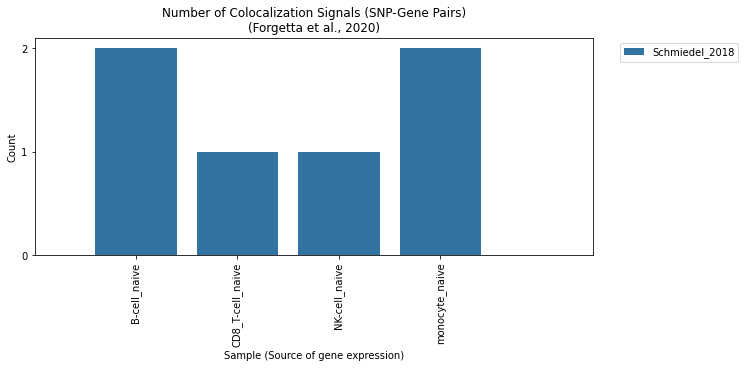

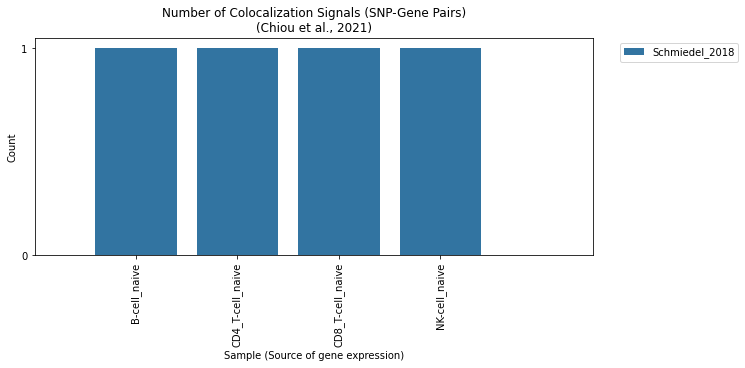

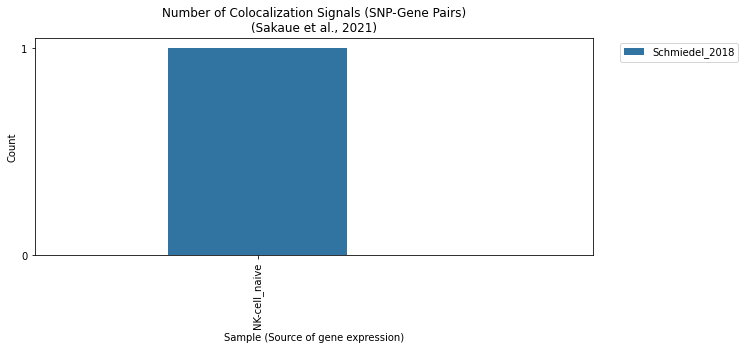

In [18]:
for gwas_source, gwas_summary in study_summary.groupby('gwas_source'):
        
    #sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="count",
                hue='eqtl_source', ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    # rotate the tick marks
    for x in g.get_xticklabels():
        x.set_rotation(90)
        

    gwas_authorship = gwas_meta.loc[gwas_source, 'authorship']
    g.set_title('Number of Colocalization Signals (SNP-Gene Pairs)\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')
    g.set_yticks(list(range(0, max(gwas_summary['count']) + 1)))
    
    # expand the x limits
    ax.set_xlim(-1, gwas_summary.ge_source.nunique() + 0.5)


In [19]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Plotting the Number of Unique Genes per Colocalization Analysis

In [20]:
uniq_genes_per_sample = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).genename.nunique()
uniq_genes_per_sample = uniq_genes_per_sample.reset_index()

In [21]:
uniq_genes_per_sample

,gwas_source,eqtl_source,ge_source,genename
0,T1D_32005708,Schmiedel_2018,B-cell_naive,2
1,T1D_32005708,Schmiedel_2018,CD8_T-cell_naive,1
2,T1D_32005708,Schmiedel_2018,NK-cell_naive,1
3,T1D_32005708,Schmiedel_2018,monocyte_naive,2
4,T1D_34012112_Gaulton,Schmiedel_2018,B-cell_naive,1
5,T1D_34012112_Gaulton,Schmiedel_2018,CD4_T-cell_naive,1
6,T1D_34012112_Gaulton,Schmiedel_2018,CD8_T-cell_naive,1
7,T1D_34012112_Gaulton,Schmiedel_2018,NK-cell_naive,1
8,T1D_34594039_GCST90018925,Schmiedel_2018,NK-cell_naive,1


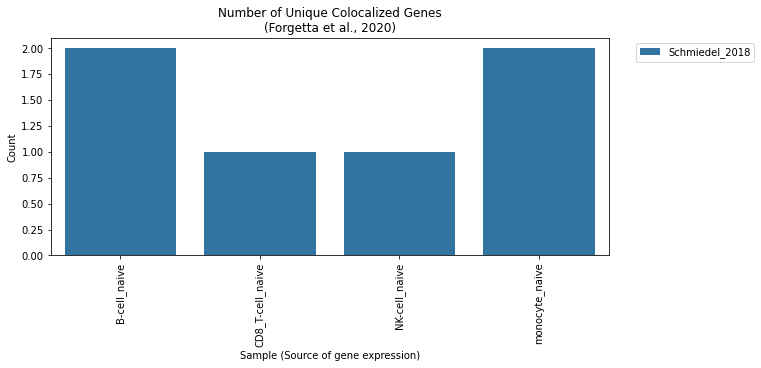

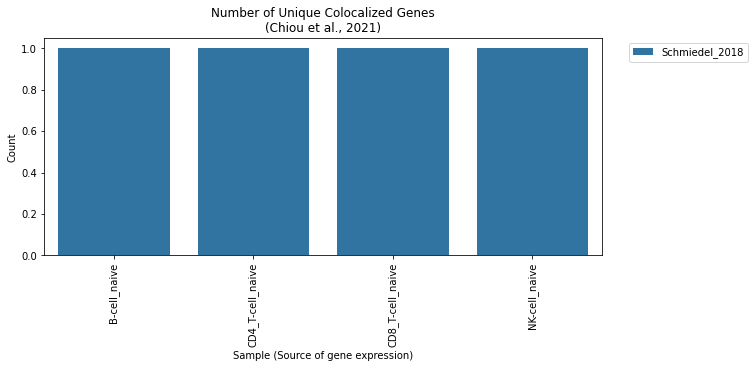

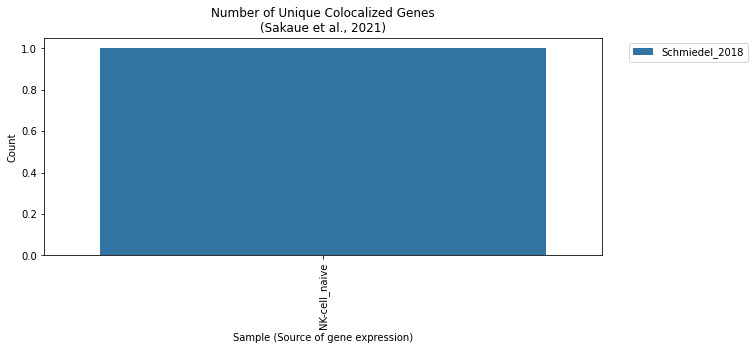

In [22]:
for gwas_source, gwas_summary in uniq_genes_per_sample.groupby('gwas_source'):
        
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="genename",
                hue='eqtl_source', ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    

    for x in g.get_xticklabels():
        x.set_rotation(90)

    gwas_authorship = gwas_meta.loc[gwas_source, 'authorship']    
    g.set_title('Number of Unique Colocalized Genes\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')

In [23]:
# find the uniq snps
uniq_snps_per_samples = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).rsid.nunique().reset_index()

### Table for the number of unique genes and snps per colocalization analyses

In [24]:
# concat the two tables
uniq_summary = uniq_genes_per_sample.merge(uniq_snps_per_samples)
uniq_summary.columns = ['gwas', 'eqtl', 'ge', 'Unique # Genes', 'Unique # SNPs']

In [25]:
pd.set_option('display.max_rows', 100) 
display(uniq_summary.sort_values(['gwas', 'Unique # SNPs'], ascending=False))
pd.set_option('display.max_rows', 20) 

,gwas,eqtl,ge,Unique # Genes,Unique # SNPs
8,T1D_34594039_GCST90018925,Schmiedel_2018,NK-cell_naive,1,1
4,T1D_34012112_Gaulton,Schmiedel_2018,B-cell_naive,1,1
5,T1D_34012112_Gaulton,Schmiedel_2018,CD4_T-cell_naive,1,1
6,T1D_34012112_Gaulton,Schmiedel_2018,CD8_T-cell_naive,1,1
7,T1D_34012112_Gaulton,Schmiedel_2018,NK-cell_naive,1,1
0,T1D_32005708,Schmiedel_2018,B-cell_naive,2,2
3,T1D_32005708,Schmiedel_2018,monocyte_naive,2,2
1,T1D_32005708,Schmiedel_2018,CD8_T-cell_naive,1,1
2,T1D_32005708,Schmiedel_2018,NK-cell_naive,1,1


## Summarizing the Unique Genes Combined Across all Colocalization Analyses

In [26]:
# construct a table of unique genes 
gene_uniq_summary = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source', 'genename']).genename.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('genename', ascending=False, inplace=True)
gene_uniq_summary.columns = ['Number of Unique Colocalizations per Gene in ALL Studies']

print('There are {} unique genes in the whole dataset.'.format(gene_uniq_summary.shape[0]))

# display this table
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

There are 9 unique genes in the whole dataset.


,Number of Unique Colocalizations per Gene in ALL Studies
RPS26,3
AL163932.1,1
AL157394.2,1
PRKCQ,1
AL157395.1,1
AL121787.1,1
AL133370.1,1
PRKCQ-AS1,1
AL354760.1,1


In [27]:
# save an enrichr file 
enrichr_fn = os.path.join(outdir, 'enrichr.input.txt')
with open(enrichr_fn, 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

AL121787.1
AL133370.1
AL157394.2
AL157395.1
AL163932.1
AL354760.1
PRKCQ
PRKCQ-AS1
RPS26


### Quick Dive into Treg Naive

In [28]:
treg = t1d_data.loc[t1d_data['ge_source'] == 'Treg_naive', :]
treg.sort_values(['chr', 'pos'], inplace=True)

/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
treg[major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id


## Quick Dive into GLIS3

Very lowly expressed according to DICE: https://dice-database.org/genes/GLIS3 and eQTL FDR is not significant. 

In [30]:
t1d_data.loc[t1d_data['genename'] == 'GLIS3', major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id


## Saving genes for excel analysis 

In [31]:
# find the unique SNPs
uniq_snps_by_cells = t1d_data.groupby('ge_source').varid.nunique()
uniq_snps_by_cells = uniq_snps_by_cells.to_frame()

#find the unique genes 
uniq_genes_by_cells = t1d_data.groupby('ge_source').gene_id.nunique()
uniq_genes_by_cells = uniq_genes_by_cells.to_frame()

# merge
uniq_counts_by_cells = pd.merge(uniq_snps_by_cells, uniq_genes_by_cells, left_index=True, right_index=True)
uniq_counts_by_cells.columns = ['Number of Unique SNPs', 'Number of Unique Genes']
uniq_counts_by_cells.index.name = 'Cell Line'

In [32]:
# save the file
excel_analysis = os.path.join(outdir, 'Unique_Counts_By_Cell_Line.xlsx')
uniq_counts_by_cells.to_excel(excel_analysis, sheet_name='colocalization')

In [33]:
excel_analysis

'results/notebooks/colocalization_with_eqtl_catalogue/Unique_Counts_By_Cell_Line.xlsx'

#### Write the gene list as well

In [34]:
gh_list = t1d_data.gene_id.unique()
gh_fn = os.path.join(outdir, 'gene_list.txt')
with open(gh_fn, 'w') as fw:
    for x in gh_list:
        fw.write('{}\n'.format(x))

#### Get the unique genes per cell type 

In [35]:
genes_by_cell = t1d_data[['ge_source', 'gene_id']].drop_duplicates()
genes_by_cell.sort_values(['ge_source', 'gene_id'], inplace=True)
genes_by_cell['source'] = 'colocalization'
genes_by_cell.columns = ['cline', 'geneid', 'source']
fn = os.path.join(outdir, 'genes_by_cell.xlsx')
genes_by_cell.to_excel(fn, index=False)